In [1]:
from datasets import load_from_disk
import torch
from torch.utils.data import DataLoader

dataset = load_from_disk('/mnt/ceph/users/polymathic/mmoma/datasets/astroclip_file/')
dataset.set_format(type='torch', columns=['spectrum'])


loader = {k:DataLoader(dataset[k], batch_size=128, shuffle=True) for k in ['train','test']}


In [2]:
# preprocessing the samples
# This step, Z-scores each sample individually and encodes
# this information is stored in the first element of each sample
# Then the sample is then unfolded into overlapping regions 
# as a continuous tokenization

import numpy as np

def slice(x, section_length=10, overlap=5):

    start_indices = np.arange(0, len(x) - overlap, section_length - overlap)
    sections = [x[start:start + section_length] for start in start_indices]

    # If the last section is not of length 'section_length', you can decide whether to keep or discard it
    if len(sections[-1]) < section_length:
        sections.pop(-1)  # Discard the last section    

    return np.concatenate(sections, 1).T

def preprocess(samples):
    out = []

    for x in samples["spectrum"]:
        x = np.array(x)
        std, mean = x.std(), x.mean()
        # skipping samples that are all zero
        if std == 0:
            continue
        x = (x - mean) / std
        x = slice(x, 194, 97)
        x = np.pad(x, pad_width=((1,0),(2,0)), mode='constant', constant_values=0)

        x[0,0] = (mean-2)/2
        x[0,1] = (std-2)/8


        out.append(x)       
    # print(len(out))
    return {"spectrum": torch.tensor(out)}

# for training we drop chunks of the spectrum
def drop_chunks(batch, size=5):
    batch['input'] = batch['spectrum'].clone()
    # random start location between 0 and length of the spectrum
    start1 = torch.randint(0, batch['spectrum'].shape[1] - 3*size-2, (1,)).item()
    start2 = torch.randint(start1+size+1, batch['spectrum'].shape[1] - 2*size-1, (1,)).item()
    start3 = torch.randint(start2+size+1, batch['spectrum'].shape[1] - size, (1,)).item()
    batch['input'][:, start1:start1+size] *= 0
    batch['input'][:, start2:start2+size] *= 0
    batch['input'][:, start3:start3+size] *= 0
    return batch

/tmp/ipykernel_1106756/998894715.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return {"spectrum": torch.tensor(out)}


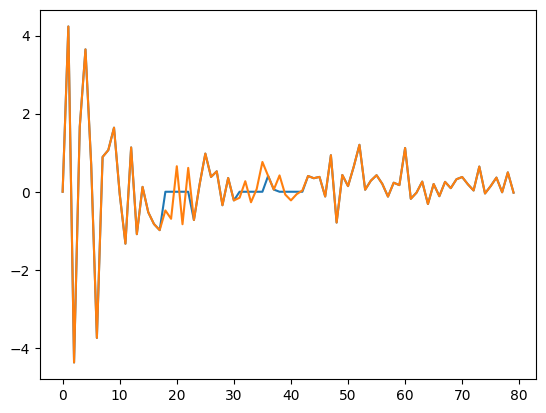

In [3]:
batch = next(iter(loader['train']))

batch_train = drop_chunks(preprocess(batch))
sp_ = batch_train['spectrum'][3,:,4]
in_ = batch_train['input'][3,:,4]

import matplotlib.pyplot as plt
plt.plot(in_, label='dropped')
plt.plot(sp_, label='original')

In [4]:
from dataclasses import dataclass

@dataclass
class SpecConfig:
    input_dim: int
    embed_dim: int
    num_layers: int
    num_heads: int
    max_len: int
    dropout: float = 0.1
    norm_first: bool = False

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class SpecFormer(nn.Module):
    config: SpecConfig

    def __init__(self, config):
        super().__init__()

        self.config = config

        self.embed = nn.Linear(config.input_dim, config.embed_dim)

        self.head = nn.Linear(config.embed_dim, 1)

        self.abs_pos = nn.Embedding(config.max_len, config.embed_dim)

        trans_layer = nn.TransformerEncoderLayer(
            d_model=config.embed_dim,
            nhead=config.num_heads,
            dim_feedforward=4 * config.embed_dim,
            dropout=config.dropout,
            activation="gelu",
            batch_first=True,
            norm_first=config.norm_first,
        )

        self.encoder_stack = nn.TransformerEncoder(
            encoder_layer=trans_layer,
            num_layers=config.num_layers,
            enable_nested_tensor=False,
        )

    def forward(self, input):
        t = input.shape[1]

        if len(input.shape) == 2:
            input = input.unsqueeze(-1)

        x = self.embed(input) + self.abs_pos.weight[:t].unsqueeze(0)

        x = F.gelu(self.encoder_stack(x))

        # adding the input back in so we model the difference
        x = input + self.head(x)

        return x

In [6]:
my_config = SpecConfig(
    input_dim=196,
    embed_dim=192,
    num_layers=3,
    num_heads=3,
    max_len=80,
    dropout=0.1,
    norm_first=False,
)

my_model = SpecFormer(my_config)

In [7]:
import torch.optim as optim
from tqdm import tqdm

# Define the loss function
loss_fn = nn.MSELoss()

def train_model(model, loader, num_epochs, lr, weight_decay):

    model.cuda()

    # Define the optimizer
    optimizer = optim.AdamW(my_model.parameters(), lr=lr, weight_decay=weight_decay)

    # add cosine annealing scheduler
    sched = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(loader)*num_epochs, lr/100)
        
    try:
        # Training loop
        for epoch in range(num_epochs):
            # Set the model to train mode
            model.train()
            
            # Initialize the total loss for this epoch
            total_loss = 0
            
            # Iterate over the training data
            for batch in tqdm(loader):

                # preprocess the batch
                batch = drop_chunks(preprocess(batch))

                # Clear the gradients
                optimizer.zero_grad()

                
                # Forward pass
                output = model(batch['input'].cuda())
                
                # Compute the loss
                loss = loss_fn(output, batch['spectrum'].cuda())
                
                # Backward pass
                loss.backward()
                
                # Update the weights
                optimizer.step()

                sched.step()
                
                # Update the total loss
                total_loss += loss.item()
            
            # Compute the average loss for this epoch
            avg_loss = total_loss / len(loader)
            
            # Print the average loss for this epoch
            print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.3g}, Learning Rate: {optimizer.param_groups[0]['lr']:.4f}")
    except KeyboardInterrupt:
        print('KeyboardInterrupt')

In [8]:
train_model(my_model, loader['train'], num_epochs=10, lr=1e-4, weight_decay=1e-3)

100%|██████████| 1238/1238 [10:25<00:00,  1.98it/s]


Epoch 1/10, Average Loss: 0.0865, Learning Rate: 0.0001


100%|██████████| 1238/1238 [09:57<00:00,  2.07it/s]


Epoch 2/10, Average Loss: 0.0757, Learning Rate: 0.0001


100%|██████████| 1238/1238 [09:53<00:00,  2.09it/s]


Epoch 3/10, Average Loss: 0.0751, Learning Rate: 0.0001


100%|██████████| 1238/1238 [09:51<00:00,  2.09it/s]


Epoch 4/10, Average Loss: 0.0769, Learning Rate: 0.0001


100%|██████████| 1238/1238 [10:32<00:00,  1.96it/s]


Epoch 5/10, Average Loss: 0.0723, Learning Rate: 0.0001


100%|██████████| 1238/1238 [10:14<00:00,  2.02it/s]


Epoch 6/10, Average Loss: 0.0717, Learning Rate: 0.0000


100%|██████████| 1238/1238 [09:57<00:00,  2.07it/s]


Epoch 7/10, Average Loss: 0.0768, Learning Rate: 0.0000


100%|██████████| 1238/1238 [09:56<00:00,  2.07it/s]


Epoch 8/10, Average Loss: 0.0730, Learning Rate: 0.0000


100%|██████████| 1238/1238 [10:02<00:00,  2.06it/s]


Epoch 9/10, Average Loss: 0.0749, Learning Rate: 0.0000


100%|██████████| 1238/1238 [10:16<00:00,  2.01it/s]

Epoch 10/10, Average Loss: 0.0749, Learning Rate: 0.0000


In [12]:
torch.save({'model_state_dict': my_model.state_dict(), 'config': my_config}, 'trained_model.pth')


In [8]:
# load the trained model

checkpoint = torch.load('trained_model.pth')
my_model = SpecFormer(checkpoint['config'])
my_model.load_state_dict(checkpoint['model_state_dict'])
my_model.cuda()

SpecFormer(
  (embed): Linear(in_features=196, out_features=192, bias=True)
  (head): Linear(in_features=192, out_features=1, bias=True)
  (abs_pos): Embedding(80, 192)
  (encoder_stack): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
        )
        (linear1): Linear(in_features=192, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=768, out_features=192, bias=True)
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
)

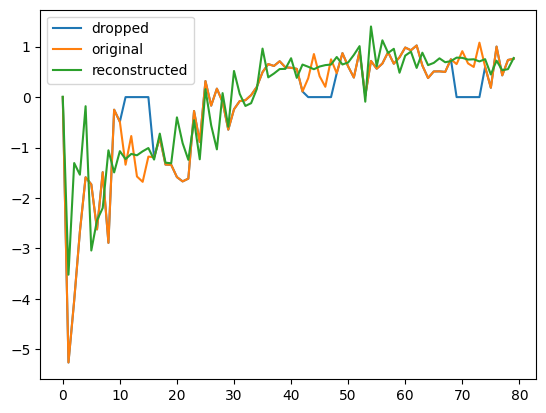

In [9]:
samp = 2

batch = next(iter(loader['train']))
batch_train = drop_chunks(preprocess(batch))
out = my_model(batch_train['input'].cuda()).cpu()

sp_ = batch_train['spectrum'][samp,:,6]
in_ = batch_train['input'][samp,:,6]

plt.plot(in_, label='dropped')
plt.plot(sp_, label='original')
plt.plot(out[samp,:,4].detach(), label='reconstructed')
plt.legend()

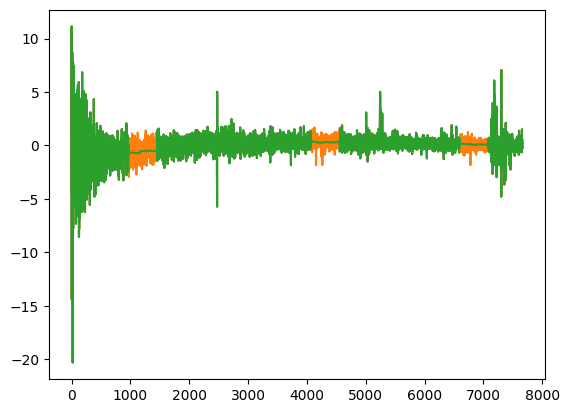

In [18]:
bs = batch['spectrum'].shape[0]
sp_rec = batch_train['spectrum'][:,1:,2:99].reshape(bs, -1)[0]
in_rec = batch_train['input'][:,1:,2:99].reshape(bs, -1)[0]
out_rec = out[:,1:,2:99].reshape(bs, -1)[0]

plt.plot(in_rec, label='dropped')
plt.plot(sp_rec, label='original')
plt.plot(out_rec.detach(), label='reconstructed')

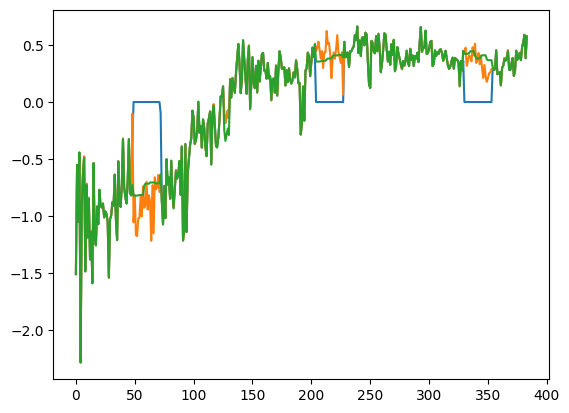

In [28]:
sample = 3

bs = batch['spectrum'].shape[0]
sp_rec = batch_train['spectrum'][:,1:,2:99].reshape(bs, -1)[sample]
in_rec = batch_train['input'][:,1:,2:99].reshape(bs, -1)[sample]
out_rec = out[:,1:,2:99].reshape(bs, -1)[sample]

# plot the moving average of the spectrum
win = 20

sp_rec = [sp_rec[i:i+20].mean().item() for i in range(0, len(sp_rec), 20)]
in_rec = [in_rec[i:i+20].mean().item() for i in range(0, len(in_rec), 20)]
out_rec = [out_rec[i:i+20].mean().item() for i in range(0, len(out_rec), 20)]

plt.plot(in_rec, label='dropped')
plt.plot(sp_rec, label='original')
plt.plot(out_rec, label='reconstructed')


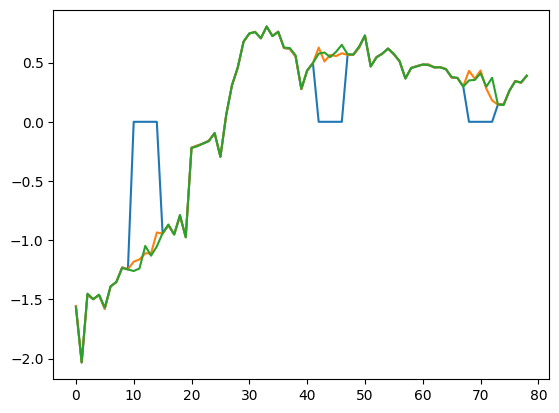

In [23]:
sample = 4

bs = batch['spectrum'].shape[0]
sp_rec = batch_train['spectrum'][:,1:,2:99].mean( -1)[sample]
in_rec = batch_train['input'][:,1:,2:99].mean( -1)[sample]
out_rec = out[:,1:,2:99].mean( -1)[sample]

plt.plot(in_rec, label='dropped')
plt.plot(sp_rec, label='original')
plt.plot(out_rec.detach(), label='reconstructed')